# IAQ TAHMİN MODELİ

In [50]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

In [52]:
dataset_5M = pd.read_csv("datasets\I_5M.csv",header =0)
dataset_5M.columns = ["Temperature","Humidity","Lux","IAQ","SharpIN","SharpOut","Sharp_Difference","PIR"]

In [53]:
dataset_5M.drop(dataset_5M.columns[[7,6,5,4]], axis=1, inplace=True)

In [54]:
dataset_5M.describe()

,Temperature,Humidity,Lux,IAQ
count,4925.000000,4925.000000,4925.000000,4925.000000
mean,19.480891,31.240105,54.348988,80.505897
std,4.093584,5.893274,91.718155,24.965028
min,0.000000,0.000000,0.000000,0.000000
25%,16.700000,27.675000,0.000000,74.000000
50%,18.868750,31.550000,0.000000,78.000000
75%,21.950000,35.562500,68.387813,99.999023
max,33.412500,47.825000,429.667350,194.111000


In [55]:
values = dataset_5M.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [56]:
scaled_dataframe = pd.DataFrame(scaled)
scaled_dataframe.describe()

,0,1,2,3
count,4925.000000,4925.000000,4925.000000,4925.000000
mean,0.583042,0.653217,0.126491,0.414742
std,0.122517,0.123226,0.213463,0.128612
min,0.000000,0.000000,0.000000,0.000000
25%,0.499813,0.578672,0.000000,0.381225
50%,0.564721,0.659697,0.000000,0.401832
75%,0.656940,0.743596,0.159165,0.515164
max,1.000000,1.000000,1.000000,1.000000


In [57]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
   
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

In [58]:
converted_time_series = series_to_supervised(scaled, 1, 1)

In [59]:
converted_time_series.drop(converted_time_series.columns[[4,5,6]], axis=1, inplace=True)
#sıcaklık nem ve ışık t leri drop edildi
#(t-1) -> 
#var4(t) -> predict edilcek
converted_time_series.describe()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
count,4924.000000,4924.000000,4924.000000,4924.000000,4924.000000
mean,0.583027,0.653224,0.126413,0.414747,0.414741
std,0.122524,0.123237,0.213415,0.128625,0.128625
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.499813,0.578672,0.000000,0.381225,0.381225
50%,0.564628,0.659827,0.000000,0.401832,0.401832
75%,0.657033,0.743694,0.158960,0.515165,0.515165
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
converted_time_series_values = converted_time_series.values

In [61]:
#train_min = 8300 #split ~ %80 train --- %20  test  
train_min = 4000

In [62]:
train_set = converted_time_series_values[:train_min,:]
test_set = converted_time_series_values[train_min:, :]

In [63]:
train_X, train_y = train_set[:, :-1], train_set[:, -1]
test_X, test_y = test_set[:, :-1], test_set[:, -1]

In [64]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4000, 1, 4) (4000,) (924, 1, 4) (924,)


Train on 4000 samples, validate on 924 samples
Epoch 1/75
 - 3s - loss: 0.3244 - val_loss: 0.1710
Epoch 2/75
 - 0s - loss: 0.1453 - val_loss: 0.0371
Epoch 3/75
 - 0s - loss: 0.1209 - val_loss: 0.0495
Epoch 4/75
 - 0s - loss: 0.1140 - val_loss: 0.0546
Epoch 5/75
 - 0s - loss: 0.1103 - val_loss: 0.0565
Epoch 6/75
 - 0s - loss: 0.1071 - val_loss: 0.0557
Epoch 7/75
 - 0s - loss: 0.1040 - val_loss: 0.0517
Epoch 8/75
 - 0s - loss: 0.1021 - val_loss: 0.0528
Epoch 9/75
 - 0s - loss: 0.0991 - val_loss: 0.0504
Epoch 10/75
 - 0s - loss: 0.0965 - val_loss: 0.0471
Epoch 11/75
 - 0s - loss: 0.0946 - val_loss: 0.0434
Epoch 12/75
 - 0s - loss: 0.0900 - val_loss: 0.0391
Epoch 13/75
 - 0s - loss: 0.0814 - val_loss: 0.0301
Epoch 14/75
 - 0s - loss: 0.0800 - val_loss: 0.0291
Epoch 15/75
 - 0s - loss: 0.0779 - val_loss: 0.0283
Epoch 16/75
 - 0s - loss: 0.0744 - val_loss: 0.0281
Epoch 17/75
 - 0s - loss: 0.0615 - val_loss: 0.0398
Epoch 18/75
 - 0s - loss: 0.0681 - val_loss: 0.0332
Epoch 19/75
 - 0s - loss: 

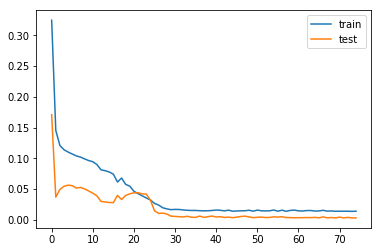

Train RMSE:   2
Test RMSE: 0.211


In [65]:
model = Sequential()
model.add(LSTM(50,activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
  
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# modeli fit ediyoruz
history = model.fit(train_X, train_y, epochs=75, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# TEST
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
#  RMSE hesaplıyoruz
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))


#TRAIN
yhat_train = model.predict(train_X)
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))

inv_yhat_train = concatenate((yhat_train, train_X[:, 1:]), axis=1)
inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
inv_yhat_train = inv_yhat_train[:,0]

train_y = train_y.reshape((len(train_y), 1))
inv_y_train = concatenate((train_y, train_X[:, 1:]), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y_train = inv_y_train[:,0]

rmse_train = sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
rmse_test = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Train RMSE: %3.f' % rmse_train)
print('Test RMSE: %.3f' % rmse_test)

#  DATA AUGMENTATION WITH GAUSSIAN NOISE

In [89]:
def lstm_model_IAQ_for_norm_dist(train_X_augmented,train_y_augmented,test_X,test_y):
    model_2 = Sequential()
    model_2.add(LSTM(50,activation='relu', input_shape=(train_X_augmented.shape[1], train_X_augmented.shape[2])))
    model_2.add(Dense(1))
    model_2.compile(loss='mae', optimizer='adam')
    # fit network
    history = model_2.fit(train_X_augmented, train_y_augmented, epochs=75, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()


    yhat = model_2.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]



    yhat_train_augmented = model_2.predict(train_X_augmented)
    train_X_augmented = train_X_augmented.reshape((train_X_augmented.shape[0], train_X_augmented.shape[2]))

    inv_yhat_train_augmented = concatenate((yhat_train_augmented, train_X_augmented[:, 1:]), axis=1)
    inv_yhat_train_augmented = scaler.inverse_transform(inv_yhat_train_augmented)
    inv_yhat_train_augmented = inv_yhat_train_augmented[:,0]

    train_y_augmented = train_y_augmented.reshape((len(train_y_augmented), 1))
    train_inv_y_augmented = concatenate((train_y_augmented, train_X_augmented[:, 1:]), axis=1)
    train_inv_y_augmented = scaler.inverse_transform(train_inv_y_augmented)
    train_inv_y_augmented = train_inv_y_augmented[:,0]




    rmse_test = sqrt(mean_squared_error(inv_y, inv_yhat))
    rmse_train = sqrt(mean_squared_error(train_inv_y_augmented, inv_yhat_train_augmented))

    print('Train RMSE: %.3f' % rmse_train)
    print('Test RMSE: %.3f' % rmse_test)
    return rmse_train


In [90]:
X = dataset_5M.iloc[:,:3]
y = dataset_5M.iloc[:,3]

In [91]:
def noise(X, y, n, sigma):
    _X = X.copy()
    _y = y.copy()
    for _ in range(n):
        X = np.r_[X, _X + np.random.randn(*_X.shape)*sigma]
        y = np.r_[y, _y]
    return X, y

In [109]:
_Xtr, _ytr = noise(X, y, 1, 1) #sigma 1
augmented_X = pd.DataFrame(_Xtr)
augmented_y = pd.DataFrame(_ytr)
augmented_data = pd.concat([augmented_X,augmented_y],axis=1)

augmented_values = augmented_data.values

In [111]:
augmented_data.describe()

,0,1,2,0
count,9850.000000,9850.000000,9850.000000,9850.000000
mean,19.485089,31.216732,54.346966,80.505897
std,4.158602,5.931816,91.710198,24.963761
min,-2.598822,-2.725960,-3.391982,0.000000
25%,16.691452,27.613191,0.000000,74.000000
50%,18.934284,31.500000,0.782955,78.000000
75%,22.006250,35.562500,68.449045,99.999023
max,34.735982,48.792534,431.069506,194.111000


Train on 9848 samples, validate on 924 samples
Epoch 1/75
 - 68s - loss: 0.2135 - val_loss: 0.0362
Epoch 2/75
 - 1s - loss: 0.0973 - val_loss: 0.0347
Epoch 3/75
 - 1s - loss: 0.0946 - val_loss: 0.0365
Epoch 4/75
 - 0s - loss: 0.0919 - val_loss: 0.0354
Epoch 5/75
 - 1s - loss: 0.0872 - val_loss: 0.0355
Epoch 6/75
 - 0s - loss: 0.0826 - val_loss: 0.0337
Epoch 7/75
 - 0s - loss: 0.0647 - val_loss: 0.0264
Epoch 8/75
 - 0s - loss: 0.0493 - val_loss: 0.0260
Epoch 9/75
 - 0s - loss: 0.0469 - val_loss: 0.0273
Epoch 10/75
 - 0s - loss: 0.0453 - val_loss: 0.0272
Epoch 11/75
 - 0s - loss: 0.0426 - val_loss: 0.0255
Epoch 12/75
 - 0s - loss: 0.0393 - val_loss: 0.0171
Epoch 13/75
 - 0s - loss: 0.0365 - val_loss: 0.0137
Epoch 14/75
 - 0s - loss: 0.0306 - val_loss: 0.0129
Epoch 15/75
 - 0s - loss: 0.0244 - val_loss: 0.0094
Epoch 16/75
 - 0s - loss: 0.0187 - val_loss: 0.0071
Epoch 17/75
 - 0s - loss: 0.0160 - val_loss: 0.0048
Epoch 18/75
 - 0s - loss: 0.0124 - val_loss: 0.0034
Epoch 19/75
 - 1s - loss:

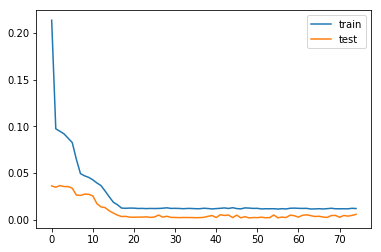

Train RMSE: 2.388
Test RMSE: 0.247
Train on 14772 samples, validate on 924 samples
Epoch 1/75
 - 12s - loss: 0.1683 - val_loss: 0.0371
Epoch 2/75
 - 1s - loss: 0.0942 - val_loss: 0.0369
Epoch 3/75
 - 1s - loss: 0.0892 - val_loss: 0.0388
Epoch 4/75
 - 1s - loss: 0.0794 - val_loss: 0.0259
Epoch 5/75
 - 1s - loss: 0.0539 - val_loss: 0.0221
Epoch 6/75
 - 1s - loss: 0.0464 - val_loss: 0.0197
Epoch 7/75
 - 1s - loss: 0.0430 - val_loss: 0.0185
Epoch 8/75
 - 1s - loss: 0.0372 - val_loss: 0.0150
Epoch 9/75
 - 1s - loss: 0.0271 - val_loss: 0.0074
Epoch 10/75
 - 1s - loss: 0.0162 - val_loss: 0.0039
Epoch 11/75
 - 1s - loss: 0.0134 - val_loss: 0.0054
Epoch 12/75
 - 1s - loss: 0.0128 - val_loss: 0.0029
Epoch 13/75
 - 1s - loss: 0.0122 - val_loss: 0.0040
Epoch 14/75
 - 1s - loss: 0.0122 - val_loss: 0.0032
Epoch 15/75
 - 1s - loss: 0.0124 - val_loss: 0.0024
Epoch 16/75
 - 1s - loss: 0.0119 - val_loss: 0.0040
Epoch 17/75
 - 1s - loss: 0.0121 - val_loss: 0.0024
Epoch 18/75
 - 1s - loss: 0.0117 - val_lo

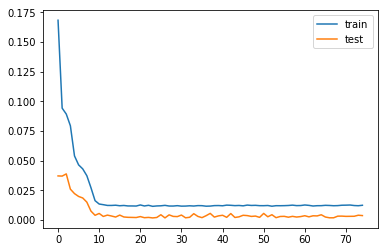

Train RMSE: 2.421
Test RMSE: 0.188
Train on 19696 samples, validate on 924 samples
Epoch 1/75
 - 7s - loss: 0.1379 - val_loss: 0.0369
Epoch 2/75
 - 1s - loss: 0.0881 - val_loss: 0.0358
Epoch 3/75
 - 1s - loss: 0.0750 - val_loss: 0.0255
Epoch 4/75
 - 1s - loss: 0.0495 - val_loss: 0.0224
Epoch 5/75
 - 1s - loss: 0.0419 - val_loss: 0.0150
Epoch 6/75
 - 1s - loss: 0.0255 - val_loss: 0.0059
Epoch 7/75
 - 1s - loss: 0.0144 - val_loss: 0.0042
Epoch 8/75
 - 1s - loss: 0.0128 - val_loss: 0.0056
Epoch 9/75
 - 1s - loss: 0.0122 - val_loss: 0.0060
Epoch 10/75
 - 1s - loss: 0.0121 - val_loss: 0.0031
Epoch 11/75
 - 1s - loss: 0.0121 - val_loss: 0.0027
Epoch 12/75
 - 1s - loss: 0.0118 - val_loss: 0.0032
Epoch 13/75
 - 1s - loss: 0.0119 - val_loss: 0.0024
Epoch 14/75
 - 1s - loss: 0.0118 - val_loss: 0.0026
Epoch 15/75
 - 1s - loss: 0.0117 - val_loss: 0.0044
Epoch 16/75
 - 1s - loss: 0.0117 - val_loss: 0.0020
Epoch 17/75
 - 1s - loss: 0.0115 - val_loss: 0.0033
Epoch 18/75
 - 1s - loss: 0.0114 - val_los

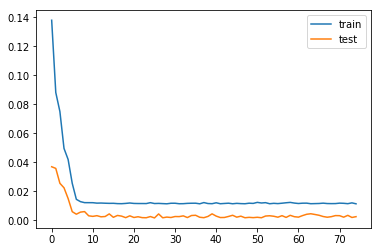

Train RMSE: 2.443
Test RMSE: 0.154
Train on 24620 samples, validate on 924 samples
Epoch 1/75
 - 7s - loss: 0.1340 - val_loss: 0.0365
Epoch 2/75
 - 1s - loss: 0.0894 - val_loss: 0.0366
Epoch 3/75
 - 1s - loss: 0.0598 - val_loss: 0.0247
Epoch 4/75
 - 1s - loss: 0.0441 - val_loss: 0.0208
Epoch 5/75
 - 1s - loss: 0.0318 - val_loss: 0.0093
Epoch 6/75
 - 1s - loss: 0.0160 - val_loss: 0.0046
Epoch 7/75
 - 1s - loss: 0.0122 - val_loss: 0.0042
Epoch 8/75
 - 1s - loss: 0.0122 - val_loss: 0.0030
Epoch 9/75
 - 1s - loss: 0.0120 - val_loss: 0.0029
Epoch 10/75
 - 1s - loss: 0.0121 - val_loss: 0.0038
Epoch 11/75
 - 1s - loss: 0.0119 - val_loss: 0.0028
Epoch 12/75
 - 1s - loss: 0.0121 - val_loss: 0.0030
Epoch 13/75
 - 1s - loss: 0.0119 - val_loss: 0.0042
Epoch 14/75
 - 1s - loss: 0.0119 - val_loss: 0.0045
Epoch 15/75
 - 1s - loss: 0.0119 - val_loss: 0.0039
Epoch 16/75
 - 1s - loss: 0.0117 - val_loss: 0.0031
Epoch 17/75
 - 1s - loss: 0.0117 - val_loss: 0.0030
Epoch 18/75
 - 1s - loss: 0.0116 - val_los

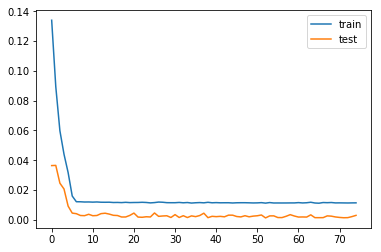

Train RMSE: 2.440
Test RMSE: 0.165
Train on 29544 samples, validate on 924 samples
Epoch 1/75
 - 8s - loss: 0.1211 - val_loss: 0.0353
Epoch 2/75
 - 1s - loss: 0.0798 - val_loss: 0.0232
Epoch 3/75
 - 1s - loss: 0.0471 - val_loss: 0.0224
Epoch 4/75
 - 1s - loss: 0.0382 - val_loss: 0.0139
Epoch 5/75
 - 1s - loss: 0.0232 - val_loss: 0.0037
Epoch 6/75
 - 1s - loss: 0.0136 - val_loss: 0.0027
Epoch 7/75
 - 1s - loss: 0.0125 - val_loss: 0.0040
Epoch 8/75
 - 1s - loss: 0.0122 - val_loss: 0.0029
Epoch 9/75
 - 1s - loss: 0.0123 - val_loss: 0.0043
Epoch 10/75
 - 1s - loss: 0.0121 - val_loss: 0.0030
Epoch 11/75
 - 1s - loss: 0.0119 - val_loss: 0.0030
Epoch 12/75
 - 1s - loss: 0.0121 - val_loss: 0.0032
Epoch 13/75
 - 1s - loss: 0.0120 - val_loss: 0.0034
Epoch 14/75
 - 1s - loss: 0.0117 - val_loss: 0.0036
Epoch 15/75
 - 1s - loss: 0.0119 - val_loss: 0.0038
Epoch 16/75
 - 1s - loss: 0.0121 - val_loss: 0.0023
Epoch 17/75
 - 1s - loss: 0.0121 - val_loss: 0.0020
Epoch 18/75
 - 1s - loss: 0.0117 - val_los

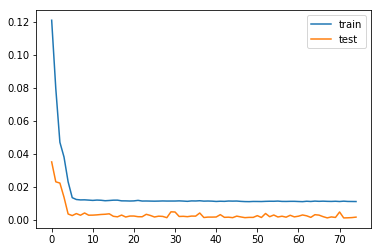

Train RMSE: 2.473
Test RMSE: 0.141


In [93]:
augmentation_size_rmse = []

augmentation_size = [1,2,3,4,5]

for i in range(0,len(augmentation_size)):
    _Xtr, _ytr = noise(X, y, augmentation_size[i], 1) #sigma 1
    augmented_X = pd.DataFrame(_Xtr)
    augmented_y = pd.DataFrame(_ytr)
    augmented_data = pd.concat([augmented_X,augmented_y],axis=1)

    augmented_values = augmented_data.values
    scaled_augmented_values = scaler.fit_transform(augmented_values)
    
    
    converted_time_series_augmented = series_to_supervised(scaled_augmented_values, 1, 1)
    converted_time_series_augmented.drop(converted_time_series_augmented.columns[[4,5,6]], axis=1, inplace=True)
    converted_time_series_values_augmented = converted_time_series_augmented.values
    #train_min_augmented = [20756,31134,41512,51890,62268]
    train_min_augmented = [9848,14772,19696,24620,29544]
    train_set_augmented = converted_time_series_values_augmented[:train_min_augmented[i],:]
    train_X_augmented, train_y_augmented = train_set_augmented[:, :-1], train_set_augmented[:, -1]
    train_X_augmented = train_X_augmented.reshape((train_X_augmented.shape[0], 1, train_X_augmented.shape[1]))
    test_X_r = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    temp_test = lstm_model_IAQ_for_norm_dist(train_X_augmented,train_y_augmented,test_X_r,test_y)
    augmentation_size_rmse.append(temp_test)
augmentation_size_rmse = pd.DataFrame(augmentation_size_rmse)
augmentation_size_rmse[1] = augmentation_size
augmentation_size_rmse.columns = ["Test RMSE","Augmentation Size"]

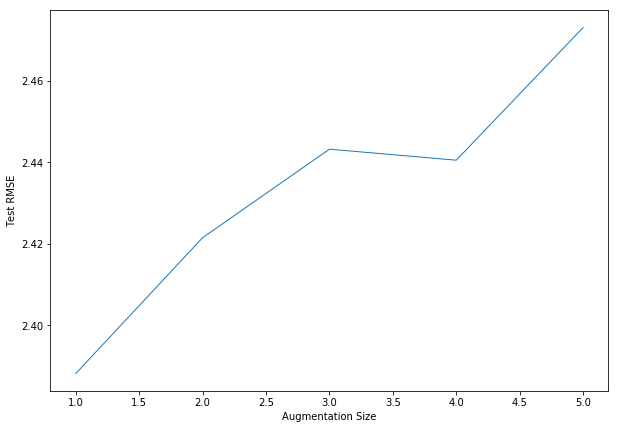

In [96]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.lineplot(x="Augmentation Size", y="Test RMSE",
                    estimator=None, lw=1,
                   data=augmentation_size_rmse)

In [113]:
augmentation_size_rmse.iloc[:,:1].values

array([[2.38816873],
       [2.4214738 ],
       [2.44317086],
       [2.44047483],
       [2.47298784]])

# DATA AUGMENTATION WITH SMOTE REGRESSION 


In [98]:
smote_dataset_scaled = pd.DataFrame(scaled)


Smote_X_data = smote_dataset_scaled.drop(smote_dataset_scaled.columns[[3]], axis=1)

Smote_y_data = smote_dataset_scaled.drop(smote_dataset_scaled.columns[[0,1,2]],axis = 1)

In [99]:
Smote_X_data = np.array(Smote_X_data)
Smote_y_data = np.array(Smote_y_data)

In [100]:
def lstm_model_IAQ_for_smote_reg(train_X_smote_augmented,train_y_smote_augmented,test_X,test_y):

    model_smote = Sequential()
    model_smote.add(LSTM(50,activation='relu', input_shape=(train_X_smote_augmented.shape[1], train_X_smote_augmented.shape[2])))

  
    model_smote.add(Dense(1))
    model_smote.compile(loss='mae', optimizer='adam')

    history = model_smote.fit(train_X_smote_augmented, train_y_smote_augmented, epochs=75, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    yhat = model_smote.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]




    yhat_train_augmented = model_smote.predict(train_X_smote_augmented)
    train_X_smote_augmented = train_X_smote_augmented.reshape((train_X_smote_augmented.shape[0], train_X_smote_augmented.shape[2]))
    inv_yhat_train_augmented = concatenate((yhat_train_augmented, train_X_smote_augmented[:, 1:]), axis=1)
    inv_yhat_train_augmented = scaler.inverse_transform(inv_yhat_train_augmented)
    inv_yhat_train_augmented = inv_yhat_train_augmented[:,0]

    train_y_smote_augmented = train_y_smote_augmented.reshape((len(train_y_smote_augmented), 1))
    train_inv_y_augmented = concatenate((train_y_smote_augmented, train_X_smote_augmented[:, 1:]), axis=1)
    train_inv_y_augmented = scaler.inverse_transform(train_inv_y_augmented)
    train_inv_y_augmented = train_inv_y_augmented[:,0]



  
    rmse_test = sqrt(mean_squared_error(inv_y, inv_yhat))
    rmse_train = sqrt(mean_squared_error(train_inv_y_augmented, inv_yhat_train_augmented))

    print('Train RMSE: %.3f' % rmse_train)
    print('Test RMSE: %.3f' % rmse_test)
    return rmse_train

In [101]:
import numpy as np
from random import randrange, choice
from sklearn.neighbors import NearestNeighbors

def SMOTE(T,N,k):

    n_minority_samples, n_features = T.shape

    if N < 100:
        N = 100
        pass
    if (N % 100) != 0:
        raise ValueError("N < 100 veya 100'ün katı olmalı")
    N = int(N/100)
    n_synthetic_samples = N * n_minority_samples
    n_synthetic_samples = int(n_synthetic_samples)
    S = np.zeros(shape=(n_synthetic_samples, n_features))
# nearest neighbours
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(T)

#Sentetik örneklerin hesaplanması
    for i in range(n_minority_samples):
        nn = neigh.kneighbors([T[i]], return_distance=False)
    
        for n in range(N):
            nn_index = choice(nn[0]) 
            while nn_index == i:
                nn_index = choice(nn[0])

            dif = T[nn_index] - T[i]
            gap = np.random.random()
            S[n + i * N, :] = T[i,:] + gap * dif[:]
    return S

Train on 9848 samples, validate on 924 samples
Epoch 1/75
 - 7s - loss: 0.1836 - val_loss: 0.0337
Epoch 2/75
 - 0s - loss: 0.0863 - val_loss: 0.0381
Epoch 3/75
 - 0s - loss: 0.0824 - val_loss: 0.0350
Epoch 4/75
 - 0s - loss: 0.0805 - val_loss: 0.0276
Epoch 5/75
 - 0s - loss: 0.0660 - val_loss: 0.0266
Epoch 6/75
 - 0s - loss: 0.0533 - val_loss: 0.0256
Epoch 7/75
 - 0s - loss: 0.0493 - val_loss: 0.0242
Epoch 8/75
 - 0s - loss: 0.0476 - val_loss: 0.0221
Epoch 9/75
 - 0s - loss: 0.0445 - val_loss: 0.0146
Epoch 10/75
 - 0s - loss: 0.0371 - val_loss: 0.0146
Epoch 11/75
 - 0s - loss: 0.0285 - val_loss: 0.0121
Epoch 12/75
 - 0s - loss: 0.0228 - val_loss: 0.0084
Epoch 13/75
 - 0s - loss: 0.0160 - val_loss: 0.0090
Epoch 14/75
 - 0s - loss: 0.0140 - val_loss: 0.0074
Epoch 15/75
 - 0s - loss: 0.0129 - val_loss: 0.0040
Epoch 16/75
 - 0s - loss: 0.0130 - val_loss: 0.0023
Epoch 17/75
 - 0s - loss: 0.0125 - val_loss: 0.0030
Epoch 18/75
 - 0s - loss: 0.0135 - val_loss: 0.0024
Epoch 19/75
 - 0s - loss: 

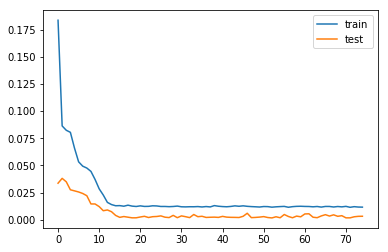

Train RMSE: 2.466
Test RMSE: 0.185
Train on 14772 samples, validate on 924 samples
Epoch 1/75
 - 6s - loss: 0.1418 - val_loss: 0.0246
Epoch 2/75
 - 1s - loss: 0.0762 - val_loss: 0.0254
Epoch 3/75
 - 1s - loss: 0.0539 - val_loss: 0.0268
Epoch 4/75
 - 1s - loss: 0.0519 - val_loss: 0.0289
Epoch 5/75
 - 1s - loss: 0.0516 - val_loss: 0.0233
Epoch 6/75
 - 1s - loss: 0.0425 - val_loss: 0.0129
Epoch 7/75
 - 1s - loss: 0.0369 - val_loss: 0.0100
Epoch 8/75
 - 1s - loss: 0.0301 - val_loss: 0.0111
Epoch 9/75
 - 1s - loss: 0.0212 - val_loss: 0.0085
Epoch 10/75
 - 1s - loss: 0.0139 - val_loss: 0.0050
Epoch 11/75
 - 1s - loss: 0.0116 - val_loss: 0.0082
Epoch 12/75
 - 1s - loss: 0.0112 - val_loss: 0.0040
Epoch 13/75
 - 1s - loss: 0.0105 - val_loss: 0.0045
Epoch 14/75
 - 1s - loss: 0.0104 - val_loss: 0.0025
Epoch 15/75
 - 1s - loss: 0.0095 - val_loss: 0.0039
Epoch 16/75
 - 1s - loss: 0.0096 - val_loss: 0.0025
Epoch 17/75
 - 1s - loss: 0.0099 - val_loss: 0.0036
Epoch 18/75
 - 1s - loss: 0.0099 - val_los

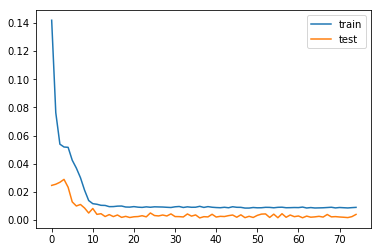

Train RMSE: 2.034
Test RMSE: 0.215
Train on 19696 samples, validate on 924 samples
Epoch 1/75
 - 7s - loss: 0.1073 - val_loss: 0.0298
Epoch 2/75
 - 1s - loss: 0.0494 - val_loss: 0.0246
Epoch 3/75
 - 1s - loss: 0.0451 - val_loss: 0.0186
Epoch 4/75
 - 1s - loss: 0.0397 - val_loss: 0.0184
Epoch 5/75
 - 1s - loss: 0.0354 - val_loss: 0.0105
Epoch 6/75
 - 1s - loss: 0.0278 - val_loss: 0.0069
Epoch 7/75
 - 1s - loss: 0.0193 - val_loss: 0.0066
Epoch 8/75
 - 1s - loss: 0.0112 - val_loss: 0.0042
Epoch 9/75
 - 1s - loss: 0.0087 - val_loss: 0.0039
Epoch 10/75
 - 1s - loss: 0.0088 - val_loss: 0.0021
Epoch 11/75
 - 1s - loss: 0.0087 - val_loss: 0.0021
Epoch 12/75
 - 1s - loss: 0.0082 - val_loss: 0.0037
Epoch 13/75
 - 1s - loss: 0.0082 - val_loss: 0.0031
Epoch 14/75
 - 1s - loss: 0.0086 - val_loss: 0.0021
Epoch 15/75
 - 1s - loss: 0.0082 - val_loss: 0.0049
Epoch 16/75
 - 1s - loss: 0.0085 - val_loss: 0.0027
Epoch 17/75
 - 1s - loss: 0.0080 - val_loss: 0.0033
Epoch 18/75
 - 1s - loss: 0.0084 - val_los

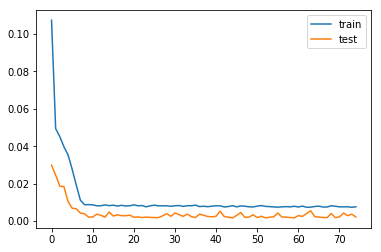

Train RMSE: 1.758
Test RMSE: 0.163
Train on 24620 samples, validate on 924 samples
Epoch 1/75
 - 7s - loss: 0.1011 - val_loss: 0.0373
Epoch 2/75
 - 1s - loss: 0.0569 - val_loss: 0.0333
Epoch 3/75
 - 1s - loss: 0.0499 - val_loss: 0.0285
Epoch 4/75
 - 1s - loss: 0.0428 - val_loss: 0.0155
Epoch 5/75
 - 1s - loss: 0.0346 - val_loss: 0.0101
Epoch 6/75
 - 1s - loss: 0.0203 - val_loss: 0.0034
Epoch 7/75
 - 1s - loss: 0.0095 - val_loss: 0.0035
Epoch 8/75
 - 1s - loss: 0.0085 - val_loss: 0.0035
Epoch 9/75
 - 1s - loss: 0.0089 - val_loss: 0.0025
Epoch 10/75
 - 1s - loss: 0.0086 - val_loss: 0.0051
Epoch 11/75
 - 1s - loss: 0.0081 - val_loss: 0.0053
Epoch 12/75
 - 1s - loss: 0.0076 - val_loss: 0.0032
Epoch 13/75
 - 1s - loss: 0.0079 - val_loss: 0.0023
Epoch 14/75
 - 1s - loss: 0.0074 - val_loss: 0.0041
Epoch 15/75
 - 1s - loss: 0.0079 - val_loss: 0.0029
Epoch 16/75
 - 1s - loss: 0.0079 - val_loss: 0.0026
Epoch 17/75
 - 1s - loss: 0.0081 - val_loss: 0.0028
Epoch 18/75
 - 1s - loss: 0.0075 - val_los

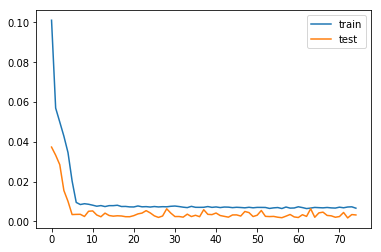

Train RMSE: 1.567
Test RMSE: 0.178
Train on 29544 samples, validate on 924 samples
Epoch 1/75
 - 8s - loss: 0.0879 - val_loss: 0.0295
Epoch 2/75
 - 1s - loss: 0.0530 - val_loss: 0.0261
Epoch 3/75
 - 1s - loss: 0.0448 - val_loss: 0.0206
Epoch 4/75
 - 1s - loss: 0.0342 - val_loss: 0.0116
Epoch 5/75
 - 1s - loss: 0.0222 - val_loss: 0.0119
Epoch 6/75
 - 1s - loss: 0.0134 - val_loss: 0.0068
Epoch 7/75
 - 1s - loss: 0.0097 - val_loss: 0.0051
Epoch 8/75
 - 1s - loss: 0.0088 - val_loss: 0.0032
Epoch 9/75
 - 1s - loss: 0.0086 - val_loss: 0.0031
Epoch 10/75
 - 1s - loss: 0.0081 - val_loss: 0.0027
Epoch 11/75
 - 1s - loss: 0.0079 - val_loss: 0.0021
Epoch 12/75
 - 1s - loss: 0.0075 - val_loss: 0.0050
Epoch 13/75
 - 1s - loss: 0.0078 - val_loss: 0.0026
Epoch 14/75
 - 1s - loss: 0.0076 - val_loss: 0.0026
Epoch 15/75
 - 1s - loss: 0.0071 - val_loss: 0.0026
Epoch 16/75
 - 1s - loss: 0.0076 - val_loss: 0.0037
Epoch 17/75
 - 1s - loss: 0.0069 - val_loss: 0.0083
Epoch 18/75
 - 1s - loss: 0.0073 - val_los

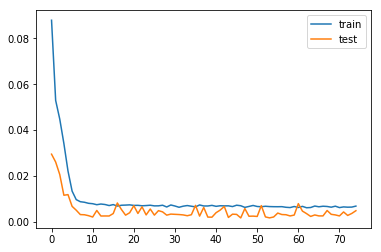

Train RMSE: 1.439
Test RMSE: 0.228


In [102]:
augmentation_size_smote_rmse = []
augmentation_size = [100,200,300,400,500]

for i in range(0,len(augmentation_size)):
    #from sklearn.neighbors import KNeighborsRegressor
    #augmented_x_smote, augmented_y_smote= smote(Smote_X_data,Smote_y_data,augmentation_size[i],5)
    from sklearn.neighbors import NearestNeighbors
    S = SMOTE(scaled,augmentation_size[i],3)
    smote_augmented_dataset = pd.DataFrame(S)
    normal_dataset = pd.DataFrame(scaled)
    smote_augmented_dataset = pd.concat([normal_dataset,smote_augmented_dataset],axis=0)
    #----------------
    #ugmented_x_smote = pd.DataFrame(augmented_x_smote)
    #ugmented_y_smote = pd.DataFrame(augmented_y_smote)

    #smote_augmented_dataset = augmented_x_smote
    #smote_augmented_dataset[3] = augmented_y_smote

    converted_time_series_smote_augmented = series_to_supervised(smote_augmented_dataset, 1, 1)
    converted_time_series_smote_augmented.drop(converted_time_series_smote_augmented.columns[[4,5,6]], axis=1, inplace=True)
    converted_time_series_values_smote_augmented = converted_time_series_smote_augmented.values



   
    #train_min_smote_augmented = [20756,31134,41512,51890,62268]
    train_min_smote_augmented = [9848,14772,19696,24620,29544]
    train_set_smote_augmented = converted_time_series_values_smote_augmented[:train_min_smote_augmented[i],:]
    train_X_smote_augmented, train_y_smote_augmented = train_set_smote_augmented[:, :-1], train_set_smote_augmented[:, -1]
    train_X_smote_augmented = train_X_smote_augmented.reshape((train_X_smote_augmented.shape[0], 1, train_X_smote_augmented.shape[1]))
    test_X_smote = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    temp_smote = lstm_model_IAQ_for_smote_reg(train_X_smote_augmented,train_y_smote_augmented,test_X_smote,test_y)
    augmentation_size_smote_rmse.append(temp_smote)
augmentation_size_smote_rmse = pd.DataFrame(augmentation_size_smote_rmse)
augmentation_size_smote_rmse[1] = augmentation_size
augmentation_size_smote_rmse.columns = ["Test RMSE","Augmentation Size"]

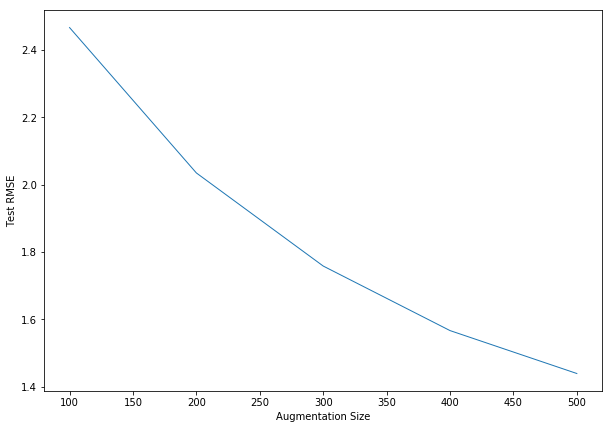

In [114]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.lineplot(x="Augmentation Size", y="Test RMSE",
                    estimator=None, lw=1,
                   data=augmentation_size_smote_rmse)

In [107]:
augmentation_size_smote_rmse.iloc[:,:1].values

array([[2.46580987],
       [2.03433315],
       [1.75808471],
       [1.56651794],
       [1.43913106]])

In [105]:
array = np.array(dataset_5M)
S = SMOTE(array,100,5)
smote_augmented_dataset = pd.DataFrame(S,columns=["Temperature","Humidity","Lux","IAQ"])
smote_augmented_dataset = pd.concat([dataset_5M,smote_augmented_dataset],axis=0)
smote_augmented_dataset.describe()

,Temperature,Humidity,Lux,IAQ
count,9850.000000,9850.000000,9850.000000,9850.000000
mean,19.470307,31.253921,54.312558,80.486961
std,4.045246,5.838276,91.647098,24.943447
min,0.000000,0.000000,0.000000,0.000000
25%,16.712500,27.673202,0.000000,74.000000
50%,18.900000,31.567849,0.000000,78.000000
75%,21.930315,35.549435,68.357670,99.999573
max,33.412500,47.825000,429.667350,194.111000


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
1,0.882856,0.565048,0.488744,0.417287,0.421152
2,0.887954,0.563643,0.471602,0.421152,0.422117
3,0.900112,0.560115,0.434196,0.422117,0.421473
4,0.899551,0.561814,0.380808,0.421473,0.417303
5,0.897119,0.563251,0.334445,0.417303,0.417287
6,0.892817,0.564558,0.297946,0.417287,0.417287
7,0.891134,0.566257,0.273009,0.417287,0.000000
8,0.886831,0.568087,0.251139,0.000000,0.000000
9,0.878788,0.570570,0.216440,0.000000,0.000000
10,0.878414,0.572922,0.178613,0.000000,0.417287
